In [1]:
from MotionGPT import *

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # device

In [3]:
loader = FBXDataLoader("Temp/", has_translate=True)
loader.LoadData()

FBXDataLoader loading data...



Hip Spine distance as scale:  3.968148177595601


In [4]:
print(len(loader.raw_data),len(loader.raw_data[0]),len(loader.raw_data[0][0]),len(loader.raw_data[0][0][0]))

4 110 65 6


In [5]:
loader.translate_scale

19.840740887978004

In [6]:
loader.PrepareTrainingData(training_joint_index=[i for i in range(len(G_MIXAMO_JOINTS))])

In [7]:
print(len(loader.all_data),len(loader.all_data[0]),len(loader.all_data[0][0]))
print(len(loader.all_data),len(loader.all_data[-1]),len(loader.all_data[-1][0]))

48 10 198
48 9 198


In [8]:
print(len(loader.train_data),len(loader.train_data[0]),len(loader.train_data[0][1]))

38 9 198


In [9]:
from SeqTransformer import *

input_dim = 198

model = build_seq_vae(input_dim, 2)

In [10]:
import numpy as np
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

6266118


In [11]:
model = torch.load("record/2020_12_08_11_06_18_transformer.pt")

ModuleNotFoundError: No module named 'transformers.models'

In [ ]:
#build model for training
if torch.cuda.is_available():
    model = model.cuda()

In [ ]:
batch_x, batch_mask = next(iter(loader.next_batch(batch_size=4)))

In [ ]:
batch_x = batch_x.to(device)
batch_mask = batch_mask.to(device)

batch_x_decoder_input = batch_x[:,1:, :] # Batch x (Length - 1) x Dim
batch_x_encoder_input = batch_x[:,:-1, :] # Batch x (Length - 1) x Dim

batch_mask_encoder_input = batch_mask[:, 1:] # Batch x (Length - 1)

batch_output, gaussian_params = model(batch_x_encoder_input, batch_x_decoder_input)


In [15]:
x = [5.14960848e-04, 7.94602465e-03, 3.43271866e-02, 4.20878172e+00,
       8.27515125e+00, 1.52564573e+01, 8.38260460e+00, 2.16090369e+00,
       1.32071948e+00, 1.40313327e-01, 6.22223139e-01, 1.15787163e-02,
       2.65505880e-01, 4.04604554e-01, 2.17958335e-02, 1.24767728e-01,
       4.55963284e-01, 2.49340320e+00, 9.06947196e-01, 1.07315816e-02,
       1.96204707e-01, 1.20311882e-03, 5.17426997e-05, 7.05120726e-07,
       1.68223057e+01, 3.26275301e+00, 3.66534081e+01, 1.68879658e-01,
       2.77914119e+00, 2.12850356e+00, 2.23719567e-01, 3.92298651e+00,
       3.94943466e+01, 1.52125559e+01, 6.62221313e-02, 2.47151923e+00,
       7.27577686e+00, 2.19598579e+00, 1.96327412e+00, 1.01847255e+00,
       3.11267829e+00, 3.14893794e+00, 4.12745628e+01, 2.26504040e+01,
       9.63078213e+00, 1.76653589e-06, 4.46148822e-03, 1.22767184e-02,
       8.72199237e-01, 1.62929583e+00, 7.67684817e-01, 2.04054475e+00,
       4.93858427e-01, 2.07079172e-01, 1.62329884e+01, 1.08361572e-01,
       3.69267762e-02, 3.08590359e-04, 8.24885760e-08, 2.01051034e-06,
       6.99692535e+00, 1.01423942e-01, 1.17383003e+01, 1.37930572e+00,
       1.41005859e-01, 4.40772884e-02, 8.31047630e+00, 8.85727815e-03,
       6.53851107e-02, 3.90516470e-05, 3.77671386e-05, 6.22384134e-04,
       5.17336652e-03, 7.31161237e-01, 1.93165421e+00, 1.39848022e+01,
       4.50690761e-02, 7.93501300e-08, 2.01776004e+00, 8.71304348e-02,
       2.34920472e-01, 5.60987217e-04, 1.75298885e-06, 8.13322898e-04,
       1.40787411e+00, 9.40491915e-01, 3.00233879e+01, 1.35745687e+01,
       8.23023677e-01, 1.69086933e+00, 1.56614995e+00, 1.36443698e+00,
       9.17405486e-02, 1.86231602e-02, 3.63804861e-06, 2.00487953e-03,
       6.08859673e+01, 1.14165567e-01, 9.35894012e+00, 3.89965324e+01,
       1.80568457e+00, 5.33030081e+00, 1.15494259e-01, 1.12137985e+01,
       8.79916847e-01, 6.32025123e-01, 2.08482623e+00, 1.39397442e+00,
       4.16417599e+00, 1.11688719e+01, 2.38951594e-02, 1.23801529e+00,
       9.06036377e+00, 1.57010520e+00, 5.23652534e+01, 5.00799045e-02,
       1.10838776e+01, 2.61781042e-05, 7.33886962e-04, 1.13955983e-04,
       2.19569236e-01, 5.06815612e-02, 5.19959354e+00, 2.20115108e+01,
       1.28057313e+00, 3.52665335e-01, 1.76398456e-01, 3.27116363e-02,
       2.18385160e-01, 8.42832436e-04, 5.72476210e-07, 3.28120564e-07,
       9.64666083e-02, 1.11701369e+00, 4.60322618e+00, 1.28100944e+00,
       3.26190203e-01, 6.81691290e-06, 2.51217022e+01, 1.77479256e-02,
       7.34727504e-03, 7.80647097e-05, 4.28485443e-08, 2.27018546e-07,
       2.35656425e-02, 8.42961669e-01, 4.20546913e+00, 2.37612739e-01,
       4.57428694e-02, 8.90936609e-03, 7.04480600e+00, 1.70018420e-01,
       4.14220184e-01, 1.86898833e-05, 2.96442195e-05, 4.40293135e-10,
       3.73309255e+00, 7.97692823e+00, 3.56698036e+01, 2.07306206e-01,
       1.32323563e+00, 3.67764942e-02, 8.95542383e-01, 8.91373456e-01,
       8.42802320e-03, 8.29237649e-07, 3.05422349e-04, 3.92351212e-05,
       1.43953234e-01, 3.97752118e+00, 1.25281298e+00, 1.59158513e-01,
       9.02204990e-01, 1.63112417e-01, 3.28658462e+00, 9.23049033e-01,
       2.94348953e-04, 5.73634148e-01, 6.63713971e-03, 6.44339249e-02,
       1.16623793e-04, 1.32949295e-04, 2.04792686e-05, 1.61013973e+00,
       5.34191513e+00, 4.78910744e-01, 6.27301884e+00, 4.05887872e-01,
       6.40724182e-01, 5.59720993e+00, 1.34720579e-01, 2.39519496e-02,
       3.45825195e+00, 2.76656449e-01, 1.02281354e-01, 1.09767844e-03,
       3.66069446e-03, 2.92741257e-04, 4.20389319e-04, 6.36786548e-03,
       1.03117852e-02, 2.10597801e+00, 1.15621006e+00, 1.42012157e+01,
       2.03814998e-01, 7.43292868e-01, 2.24971175e+00, 1.03862352e+01,
       1.27413673e-02, 2.48066902e-01, 5.58242798e+00, 4.46879584e-03,
       2.65123457e-01, 3.56932616e+00, 2.02708840e+00, 2.67416716e+00,
       4.38344628e-01, 9.96887779e+00, 5.32438612e+00, 9.52369708e-04,
       1.12073707e-04, 3.15561124e-07, 2.47455382e+00, 2.37268972e+00,
       3.01364124e-01, 1.62526379e+01, 3.30172706e+00, 2.35132337e-01,
       1.71937749e-01, 2.60357189e+00, 4.06704903e+00, 1.22723942e+01,
       1.83495789e+01, 4.42913622e-01, 1.25649941e+00, 1.72990620e+00,
       2.60876632e+00, 5.62200285e-02, 5.26849842e+00, 8.68599224e+00,
       5.72807121e+01, 1.94089127e+01, 6.32323861e-01, 3.15543025e-06,
       3.36335716e-03, 1.08905463e-02, 6.78949893e-01, 3.15856218e+00,
       5.72663210e-02, 4.92806658e-02, 5.85879326e-01, 1.04639858e-01,
       1.70490952e+01, 1.93860903e-01, 9.23351794e-02, 4.05946688e-04,
       8.12269030e-10, 3.57986664e-06, 9.24100208e+00, 1.00099109e-01,
       1.26135750e+01, 4.02828127e-01, 5.11693116e-03, 1.04528368e-01,
       1.55725920e+00, 3.26736681e-02, 1.67671405e-02, 3.18458005e-05,
       1.24290527e-04, 7.65379053e-04, 3.07570547e-02, 9.13139939e-01,
       1.80229020e+00, 1.88267612e+01, 6.06206805e-03, 6.68174922e-02,
       5.14246285e-01, 2.50565141e-01, 2.95444429e-01, 6.38018362e-04,
       1.94316272e-06, 4.23119345e-04, 4.41313457e+00, 2.27811790e+00,
       2.06564007e+01, 1.21561460e+01, 2.52061009e+00, 1.46272516e+00,
       1.09760916e+00, 2.05654478e+00, 9.71437618e-02, 1.55578330e-02,
       6.81346268e-09, 1.93359389e-03, 2.78879523e+00, 1.00352978e-02,
       1.63199198e+00, 1.15981735e-01, 2.14988336e-01, 1.66057244e-01,
       4.77491856e-01, 9.30016899e+00, 1.19480622e+00, 5.26393294e-01,
       6.94364071e+00, 7.82134384e-02, 7.24460697e+00, 3.12804163e-01,
       3.43751979e+00, 8.87513876e-01, 1.01590881e+01, 2.12003970e+00,
       3.85191765e+01, 2.75645137e-01, 2.13395443e+01, 8.21502035e-05,
       4.47179511e-04, 8.40756940e-08, 3.96468544e+00, 2.42600232e-01,
       2.27838230e+00, 1.86971531e+01, 1.62664163e+00, 2.25803420e-01,
       1.55989754e+00, 4.60503697e-02, 5.02942026e-01, 7.73702981e-04,
       5.73040438e-07, 1.36940344e-07, 1.27914488e+00, 8.27572167e-01,
       2.67330647e+00, 3.57639603e-02, 1.81385010e-01, 1.06455602e-01,
       4.88806772e+00, 3.54012172e-03, 2.35413463e-04, 1.15654053e-04,
       3.99282314e-08, 9.33804586e-07, 2.76721263e+00, 3.90558243e-01,
       2.26823568e+00, 2.91683459e+00, 4.75545898e-02, 1.00494236e-01,
       1.43201456e+01, 3.83797884e-01, 7.00831473e-01, 3.45010812e-05,
       3.32353047e-05, 9.21808294e-07, 8.07601273e-01, 4.03315735e+00,
       2.20291176e+01, 1.48583740e-01, 3.74253821e+00, 3.92412208e-03,
       1.22128117e+00, 1.52392972e+00, 1.85511410e-04, 9.25808408e-08,
       4.02472098e-04, 2.21125234e-07, 2.01178059e-01, 1.08526773e+01,
       2.72252393e+00, 2.27863932e+00, 1.67751741e+00, 9.64614302e-02,
       5.44498205e-01, 1.03867121e-01, 9.08932745e-01, 5.05953245e-02,
       2.10755994e-03, 7.49745406e-04, 1.13131216e-06, 1.54678783e-04,
       1.66463578e-05, 3.71058416e+00, 2.35417113e-01, 7.09203303e-01,
       1.80765353e-02, 2.37240911e+00, 4.46920237e-03, 1.56106746e+00,
       1.40506017e+00, 3.06501150e+00, 1.62414372e+00, 2.13765904e-01,
       1.21482216e-01, 9.96428891e-04, 4.08780668e-03, 1.93436208e-04,
       3.06590926e-04, 2.23049033e-03, 2.73477063e-02, 2.07014233e-02,
       1.63046157e+00, 1.49831190e+01, 6.60005748e-01, 1.67895660e-01,
       2.39892244e+00, 1.17841978e+01, 3.82058858e-03, 2.02036910e-02,
       6.34157801e+00, 1.10244406e-02, 1.80702526e-02, 3.35791802e+00,
       1.50264657e+00, 1.53208303e+00, 1.39897528e+01, 1.60057306e-01,
       3.15294147e+00, 5.53698104e-04, 1.29616266e-04, 8.77074342e-08,
       2.05105066e+00, 2.53616095e+00, 8.73365307e+00, 4.63208542e+01,
       3.08788509e+01, 1.83292612e-01, 5.72889030e-01, 3.52802545e-01,
       3.79952717e+00, 3.67063731e-01, 1.98109436e+01, 7.38877833e-01,
       3.73637867e+00, 4.94305849e+00, 2.64662886e+00, 1.80356205e+00,
       7.74314356e+00, 3.56386876e+00, 4.43815155e+01, 1.71068954e+01,
       8.41921520e+00, 3.04534478e-06, 1.83498161e-03, 6.27157651e-03,
       1.30644172e-01, 3.18020368e+00, 1.24530941e-01, 9.56352520e+00,
       2.97316939e-01, 4.08100300e-02, 7.40189362e+00, 1.72007874e-01,
       1.46067142e-01, 4.22745245e-04, 7.03942433e-08, 3.79444532e-06,
       7.92214489e+00, 2.76181940e-02, 1.12499599e+01, 2.29683990e+01,
       6.29406571e-02, 1.45846969e-02, 8.63159561e+00, 2.09303778e-02,
       8.01595226e-02, 1.35651462e-05, 1.16498348e-04, 2.12438768e-04,
       1.95571280e+00, 4.26102489e-01, 1.85798323e+00, 1.00040150e+01,
       9.49006528e-03, 6.30396903e-02, 1.57287600e-03, 9.04521495e-02,
       3.58209908e-01, 1.04767689e-03, 1.35923767e-06, 2.85961753e-04,
       8.28731656e-01, 8.79674435e-01, 2.15538330e+01, 2.26398830e+01,
       1.48295999e+00, 1.81917477e+00, 8.05302620e-01, 1.66509712e+00,
       1.12971172e-01, 8.25575367e-03, 7.42386533e-07, 9.61275888e-04,
       8.64147758e+00, 1.56764954e-01, 1.42587957e+01, 3.32695335e-01,
       1.47296235e-01, 2.60933582e-03, 4.24232006e-01, 7.02884293e+00,
       1.42038298e+00, 8.39014626e+00, 1.06751406e+00, 4.85385847e+00,
       3.39495993e+00, 2.79064924e-01, 8.67585465e-02, 5.17631769e+00,
       2.70754838e+00, 2.82188201e+00, 3.61269073e+01, 3.72357607e+00,
       1.00905406e+00, 1.18217838e-04, 3.90517496e-04, 8.36546533e-05,
       3.84806657e+00, 2.19488586e-03, 2.66138148e+00, 9.48373222e+00,
       1.74120820e+00, 4.57869470e-01, 1.16171551e+01, 2.22002417e-02,
       6.15618527e-01, 5.89255942e-04, 1.36689550e-07, 2.24296187e-07,
       4.90702820e+00, 1.28468299e+00, 2.63496184e+00, 3.90073943e+00,
       4.56030428e-01, 3.36111337e-02, 1.33815813e+00, 3.67798668e-04,
       4.13248781e-04, 1.41042823e-04, 8.22471762e-08, 1.12939085e-06,
       9.95955467e+00, 4.99072254e-01, 1.22458637e+00, 4.49011040e+00,
       4.91519272e-02, 3.37649062e-02, 1.04055614e+01, 4.36403006e-01,
       4.72242296e-01, 5.71765395e-06, 3.11430886e-05, 5.13177156e-07,
       8.93853724e-01, 2.71526289e+00, 1.85743732e+01, 1.76077621e-04,
       1.62816143e+00, 4.35117893e-02, 6.71417856e+00, 9.66469526e-01,
       9.23639629e-03, 2.00524148e-08, 4.25994018e-04, 7.92403989e-06,
       3.38550043e+00, 6.38002586e+00, 8.44690979e-01, 7.18551779e+00,
       3.72257876e+00, 1.12069495e-01, 6.81987107e-01, 6.05834484e-01,
       5.31300008e-01, 3.72401416e-01, 9.00776871e-03, 2.46927552e-02,
       6.02447108e-05, 5.68316682e-05, 1.04072060e-05, 6.37476110e+00,
       6.72488630e-01, 1.22625220e+00, 3.60977292e-01, 8.35645485e+00,
       8.11816931e-01, 7.42398808e-03, 3.88981891e+00, 3.58388662e-01,
       8.36300015e-01, 3.75724763e-01, 8.70860517e-02, 6.82595943e-04,
       2.49451119e-03, 1.05217609e-04, 5.05280623e-04, 1.85653719e-03,
       1.07957162e-02, 3.24244909e-02, 1.35685384e+00, 1.44980373e+01,
       2.21512723e+00, 5.02778888e-01, 1.65952778e+00, 1.42373845e-01,
       8.25008284e-03, 5.00822365e-01, 1.99072158e+00, 1.01229157e-02,
       5.39437175e-01, 3.83871841e+00, 2.14127994e+00, 5.33994317e-01,
       4.12169075e+00, 4.63689232e+01, 1.09244478e+00, 7.16323964e-04,
       1.84820557e-04, 2.80941572e-06, 1.44081573e+01, 6.63559139e-01,
       1.67309647e+01, 4.79016453e-02, 1.62527263e+00, 8.49401474e-01,
       7.10988939e-02, 5.39272606e-01, 3.25983390e-02, 5.94769573e+00,
       2.45738049e+01, 1.78079498e+00, 2.91821098e+00, 7.35943413e+00,
       1.34111851e-01, 1.77505934e+00, 1.08799672e+00, 1.25306072e+01,
       7.91311798e+01, 2.95832005e+01, 1.24432850e+00, 1.46662285e-06,
       2.08743289e-03, 7.09030684e-03, 2.50210792e-01, 2.53374791e+00,
       1.76416293e-01, 1.65500617e+00, 5.29068112e-01, 1.39966859e-02,
       4.12373734e+00, 1.56416133e-01, 2.61389315e-01, 4.88082878e-04,
       3.78497340e-08, 2.22754534e-06, 5.45043945e+00, 3.99262737e-03,
       1.47402344e+01, 7.66204357e+00, 1.03185493e-02, 6.41394854e-02,
       7.94565487e+00, 3.73829645e-03, 5.01264930e-02, 2.08106831e-05,
       1.97352128e-04, 4.48054139e-04, 1.86228022e-01, 2.99053103e-01,
       1.50062597e+00, 5.31302094e-01, 1.19041800e-01, 3.26146752e-01,
       1.59834683e+00, 6.95571423e-01, 4.52008337e-01, 5.10980492e-04,
       8.24502536e-07, 2.93919613e-04, 4.39558601e+00, 3.74077606e+00,
       1.98321915e+01, 2.60914669e+01, 3.28943014e+00, 3.13592601e+00,
       7.42287040e-01, 2.48060036e+00, 2.19982401e-01, 9.42988228e-03,
       1.32406103e-06, 1.30279560e-03, 7.04395142e+01, 1.06713188e+00,
       6.90234566e+00, 1.16049528e+00, 1.50015748e+00, 4.89636993e+00,
       3.07064891e-01, 8.39765644e+00, 6.87306643e-01, 4.04285765e+00,
       7.17872953e+00, 4.47932929e-01, 3.82364702e+00, 1.80370903e+00,
       2.22177219e+00, 1.31415091e-02, 1.57949162e+01, 2.63600254e+00,
       2.56208687e+01, 4.51568998e-02, 2.17957916e+01, 1.52313063e-04,
       2.15133943e-04, 1.16078583e-04, 2.17520207e-01, 6.80634916e-01,
       3.93093801e+00, 1.46405258e+01, 1.85293031e+00, 1.80057570e-01,
       1.29152994e+01, 3.20130698e-02, 9.18431878e-01, 6.93486189e-04,
       1.56585017e-07, 2.34582657e-07, 1.79701418e-01, 9.07340467e-01,
       3.32750654e+00, 8.50813091e-02, 2.07645252e-01, 5.75867295e-02,
       3.58882952e+00, 3.23387096e-04, 5.10207610e-06, 1.75279012e-04,
       1.63568732e-08, 4.82542191e-07, 5.19241238e+00, 5.54472208e-01,
       3.06450462e+00, 6.50540495e+00, 9.08838660e-02, 1.80238903e-01,
       1.76727695e+01, 6.67477369e-01, 8.31032157e-01, 1.78840619e-05,
       3.57035933e-05, 1.97350982e-06, 1.58948052e+00, 1.04518402e+00,
       2.43149185e+01, 5.53231597e-01, 4.58996677e+00, 7.49040674e-03,
       1.53013480e+00, 1.76111102e+00, 4.57604928e-03, 1.60151637e-06,
       4.81141731e-04, 2.78595908e-05, 9.10015583e+00, 5.01905155e+00,
       8.36893654e+00, 5.21711111e+00, 9.68988419e+00, 6.93926634e-03,
       1.25652409e+00, 1.52931184e-01, 3.23472500e+00, 2.81633576e-03,
       4.92901854e-05, 1.02529780e-03, 5.04547243e-05, 1.07201384e-04,
       1.30360877e-05, 2.05791259e+00, 1.67792439e-02, 1.60559803e-01,
       6.77819443e+00, 5.69260788e+00, 8.93119514e-01, 3.94379282e+00,
       4.51555634e+00, 3.67000759e-01, 8.37478220e-01, 3.97458345e-01,
       2.15946048e-01, 8.64474394e-04, 3.09908809e-03, 8.99124570e-05,
       4.82521937e-05, 4.79247607e-03, 1.22754611e-02, 3.35163593e+00,
       1.91601906e-02, 8.47608948e+00, 2.09056959e-01, 7.08408058e-01,
       9.70880210e-01, 9.85550761e-01, 1.73932120e-01, 2.11649284e-01,
       2.42499961e-03, 1.35197401e-01, 2.18853176e-01, 6.56877995e-01,
       3.41520739e+00, 3.14599466e+00, 4.71494102e+00, 8.30013752e+00,
       7.21196234e-01, 1.12344592e-03, 1.48660416e-04, 2.26389807e-06,
       5.23487106e-03, 3.63033205e-01, 3.84938359e+00, 1.79279006e+00,
       3.05326611e-01, 7.78415298e+00, 1.60834298e-01, 5.92297688e-02,
       1.26893592e+00, 4.00369354e-02, 8.78628349e+00, 2.72581667e-01,
       2.90678239e+00, 6.64000511e-01, 6.74249470e-01, 2.26047188e-01,
       4.72648665e-02, 1.81720352e+01, 4.95072441e+01, 2.98749943e+01,
       6.24604803e-03, 3.44895807e-06, 3.55423219e-03, 1.09369159e-02,
       6.83042267e-03, 2.32543468e+00, 4.10300819e-03, 2.77305424e-01,
       3.88626844e-01, 2.97634527e-02, 2.27963867e+01, 1.92507938e-01,
       7.24236667e-02, 4.98365669e-04, 3.31709629e-08, 3.76533148e-06,
       4.87570286e+00, 1.22209042e-02, 1.22699986e+01, 1.42893612e+00,
       1.34787285e-06, 4.75875065e-02, 1.57252803e-01, 3.09289787e-02,
       1.05841719e-02, 4.19671815e-05, 1.72415283e-04, 5.88703959e-04,
       7.84313604e-02, 2.14584261e-01, 8.52072239e-01, 6.52685690e+00,
       3.86859812e-02, 2.59514838e-01, 1.38485765e+00, 3.56363177e-01,
       2.53306508e-01, 3.28351627e-04, 2.78434413e-06, 6.26771711e-04,
       3.89233887e-01, 8.12965333e-01, 1.88184204e+01, 2.09853287e+01,
       2.54343200e+00, 2.88217568e+00, 5.96239269e-01, 1.94597578e+00,
       1.33285284e-01, 1.55861229e-02, 1.09816597e-07, 1.96266337e-03,
       2.10963707e+01, 1.81484640e-01, 8.61213970e+00, 7.10092878e+00,
       1.04413474e+00, 9.19892482e-05, 4.93585795e-01, 7.32031155e+00,
       3.68976384e-01, 5.56201994e-01, 3.31523943e+00, 5.01191854e-01,
       5.67055321e+00, 1.10518765e+00, 2.15742278e+00, 1.09650046e-02,
       8.83471394e+00, 8.82518411e-01, 4.24568596e+01, 2.32773889e-02,
       1.98820229e+01, 1.06076957e-04, 2.99981475e-04, 4.66114989e-06,
       3.22068274e-01, 2.83723950e-01, 1.41317821e+00, 1.05631447e+01,
       1.60936797e+00, 2.38566443e-01, 5.09524584e+00, 2.32303347e-02,
       5.51476479e-01, 9.26358160e-04, 7.59262264e-07, 9.32054576e-08,
       2.65901797e-02, 7.68686175e-01, 1.73338747e+00, 2.16021943e+00,
       2.17152297e-01, 1.36289969e-01, 9.39531612e+00, 2.33015721e-03,
       3.29500507e-03, 1.32044297e-04, 2.24966016e-07, 1.10799340e-06,
       3.83371997e+00, 6.14156902e-01, 2.32781601e+00, 6.59621525e+00,
       5.03627099e-02, 1.55196786e-01, 8.45044708e+00, 4.16697562e-01,
       5.54962456e-01, 1.66117825e-05, 3.69370246e-05, 1.69620819e-06,
       7.81764269e-01, 3.35553479e+00, 2.87437840e+01, 1.48699939e-01,
       3.61461067e+00, 2.18362990e-03, 4.07142210e+00, 1.29688776e+00,
       5.05350879e-04, 1.23760253e-06, 4.94954875e-04, 7.31214300e-07,
       2.23953509e+00, 7.03348064e+00, 2.32225084e+00, 3.54215443e-01,
       8.50116432e-01, 2.43267454e-02, 1.82735473e-01, 3.45698357e-01,
       3.00912762e+00, 3.00435908e-02, 4.98938896e-02, 9.14248172e-03,
       1.21845387e-05, 1.15709685e-04, 2.14204738e-05, 2.45384261e-01,
       6.80066179e-03, 1.97707105e+00, 1.27610855e+01, 1.75107658e+00,
       1.36510283e-01, 5.46685314e+00, 5.66232824e+00, 5.08383691e-01,
       1.34322941e+00, 2.19020531e-01, 1.43285751e-01, 1.18636014e-03,
       4.13554721e-03, 1.99337432e-04, 3.48873287e-01, 5.40513583e-02,
       1.49213094e-02, 8.87126221e+02, 1.56088440e+03, 1.41147232e+02,
       2.68995399e+01, 2.99674058e+00, 1.48251605e+00, 8.86408329e+00]  

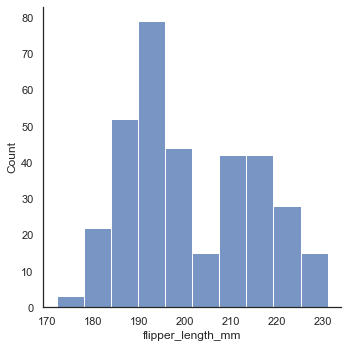

In [29]:
import seaborn as sns, numpy as np, matplotlib.pyplot as plt
sns.set_style("white")
penguins = sns.load_dataset("penguins")
sns.displot(penguins["flipper_length_mm"])
plt.show()

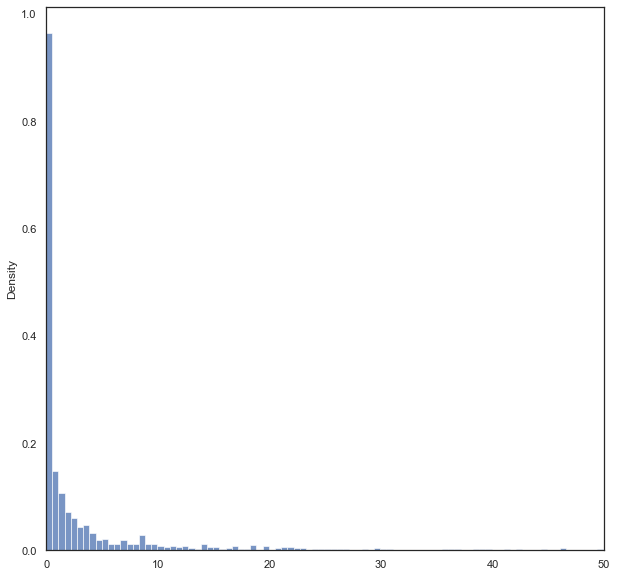

In [41]:
plt.figure(figsize=(10,10))
plt.xlim(0,50)
ax = sns.histplot(np.array(x),stat="density")